In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import datetime

In [46]:
import os
import math
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import numpy as np
from tqdm import tqdm


In [4]:
DATA_DIR = "Guava Fruit Data"          
IMAGE_SIZE = (160, 160)     
BATCH_SIZE = 32             
INITIAL_EPOCHS = 6
FINE_TUNE_EPOCHS = 8
FINE_TUNE_AT = -40          
LEARNING_RATE_HEAD = 1e-3
LEARNING_RATE_FINE = 1e-5
SEED = 42
AUTOTUNE = tf.data.AUTOTUNE
RESULTS_DIR = "results"
os.makedirs(RESULTS_DIR, exist_ok=True)

In [6]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except:
        pass
    # enable mixed precision only when GPU present
    from tensorflow.keras import mixed_precision
    mixed_precision.set_global_policy('mixed_float16')
    print("Mixed precision enabled.")
else:
    print("No GPU found — running in CPU mode (mixed precision disabled).")

No GPU found — running in CPU mode (mixed precision disabled).


In [52]:
augmenter = ImageDataGenerator(
    rotation_range=25,
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range=0.2,
    shear_range=0.1,
    brightness_range=(0.8, 1.2),
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode="nearest"
)


In [63]:
import tensorflow as tf
import os
import numpy as np
from PIL import Image
from tqdm import tqdm

# CONFIG
base_dir = "Guava Fruit Data"          # main dataset folder
target_count = 11000        # desired images per class
image_size = (160, 160)     # same as model input

# Augmentation pipeline (TensorFlow ops, faster)
def augment_image(img):
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_brightness(img, max_delta=0.15)
    img = tf.image.random_contrast(img, 0.8, 1.2)
    img = tf.image.random_saturation(img, 0.8, 1.2)
    img = tf.image.random_jpeg_quality(img, 80, 100)
    img = tf.image.random_hue(img, 0.02)
    img = tf.image.resize_with_crop_or_pad(img, image_size[0], image_size[1])
    return img

def augment_folder_tf(folder_path, target=target_count):
    img_files = [f for f in os.listdir(folder_path)
                 if f.lower().endswith(('.jpg','.png','.jpeg'))]
    current = len(img_files)
    print(f"\n📁 {os.path.basename(folder_path)}: {current} images")

    if current >= target:
        print("✅ Already sufficient, skipping.")
        return

    needed = target - current
    save_dir = os.path.join(folder_path, "augmented_tf")
    os.makedirs(save_dir, exist_ok=True)

    img_paths = [os.path.join(folder_path, f) for f in img_files]
    count = 0
    for path in tqdm(img_paths, desc=f"Augmenting {os.path.basename(folder_path)}"):
        try:
            img = Image.open(path).convert("RGB").resize(image_size)
            img_arr = np.array(img)
            for i in range(needed // current + 1):
                augmented = augment_image(tf.convert_to_tensor(img_arr))
                augmented = tf.cast(augmented, tf.uint8).numpy()
                Image.fromarray(augmented).save(
                    os.path.join(save_dir, f"aug_{count}.jpg"), quality=95)
                count += 1
                if count >= needed:
                    break
            if count >= needed:
                break
        except Exception as e:
            print("⚠️ Error:", e)
    print(f"✅ Done: Generated {count} new images.")

for folder in os.listdir(base_dir):
    path = os.path.join(base_dir, folder)
    if os.path.isdir(path):
        augment_folder_tf(path)



📁 anthracnose_fruit: 1544 images


Augmenting anthracnose_fruit:  87%|███████▊ | 1350/1544 [00:41<00:06, 32.32it/s]


✅ Done: Generated 9456 new images.

📁 Styler end root: 262 images


Augmenting Styler end root: 100%|████████████▉| 261/262 [01:11<00:00,  3.66it/s]


✅ Done: Generated 10738 new images.

📁 Fruitfly_fruit: 1312 images


Augmenting Fruitfly_fruit:  92%|███████████ | 1210/1312 [00:42<00:03, 28.40it/s]


✅ Done: Generated 9688 new images.

📁 Healthy_fruit: 928 images


Augmenting Healthy_fruit:  99%|██████████████▊| 915/928 [00:41<00:00, 22.13it/s]

✅ Done: Generated 10072 new images.


In [65]:
DATASET_DIR = DATA_DIR


train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_DIR,
    validation_split=0.1,
    subset="training",
    seed=SEED,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_DIR,
    validation_split=0.1,
    subset="validation",
    seed=SEED,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

class_names = train_ds.class_names
num_classes = len(class_names)
print("Classes:", class_names)

Found 50837 files belonging to 4 classes.
Using 45754 files for training.
Found 50837 files belonging to 4 classes.
Using 5083 files for validation.
Classes: ['Fruitfly_fruit', 'Healthy_fruit', 'Styler end root', 'anthracnose_fruit']


In [67]:
TEST_DIR = os.path.join(DATASET_DIR, "test")
if os.path.isdir(TEST_DIR):
    test_ds = tf.keras.preprocessing.image_dataset_from_directory(
        TEST_DIR,
        seed=SEED,
        image_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE
    )
    print("Loaded test dataset from 'test/' directory.")
else:
   
    test_ds = val_ds.take(max(1, int(0.2 * tf.data.experimental.cardinality(val_ds).numpy())))


In [69]:
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)
test_ds = test_ds.prefetch(AUTOTUNE)


In [71]:
y_train = np.concatenate([y.numpy() for x, y in train_ds], axis=0)
class_weights_raw = compute_class_weight('balanced', classes=np.arange(num_classes), y=y_train)
class_weights = dict(enumerate(class_weights_raw))
print("Class weights:", class_weights)

Class weights: {0: 1.155754268970395, 1: 1.155754268970395, 2: 1.094383849980865, 3: 0.7375870518442095}


In [73]:
IMG_SHAPE = IMAGE_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet',
    alpha=0.35
)
base_model.trainable = False

inputs = layers.Input(shape=IMG_SHAPE)


x = layers.Rescaling(1.0 / 127.5, offset=-1)(inputs)


x = base_model(x, training=False)


x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_classes, activation='softmax', dtype='float32')(x)

model = models.Model(inputs, outputs)


outputs = layers.Dense(num_classes, activation='softmax', dtype='float32')(x)
model = models.Model(inputs, outputs)
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_0.35_160            │ (None, 5, 5, 1280)     │       410,208 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │         5,124 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 415,332 (1.58 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 410,208 (1.56 MB)

In [75]:
now = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
ckpt_path = os.path.join(RESULTS_DIR, f"best_model_{now}.h5")
callbacks = [
    keras.callbacks.ModelCheckpoint(ckpt_path, save_best_only=True, monitor='val_loss', verbose=1),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1),
    keras.callbacks.TensorBoard(log_dir=os.path.join("logs", now))
]

In [77]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE_HEAD),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_head = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=INITIAL_EPOCHS,
    class_weight=class_weights,
    callbacks=callbacks
)


Epoch 1/6
1430/1430 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9072 - loss: 0.2430
Epoch 1: val_loss improved from None to 0.04762, saving model to results/best_model_20251110-101814.h5


1430/1430 ━━━━━━━━━━━━━━━━━━━━ 93s 64ms/step - accuracy: 0.9532 - loss: 0.1297 - val_accuracy: 0.9860 - val_loss: 0.0476 - learning_rate: 0.0010
Epoch 2/6
1430/1430 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.9787 - loss: 0.0606
Epoch 2: val_loss improved from 0.04762 to 0.03052, saving model to results/best_model_20251110-101814.h5


1430/1430 ━━━━━━━━━━━━━━━━━━━━ 152s 106ms/step - accuracy: 0.9797 - loss: 0.0573 - val_accuracy: 0.9921 - val_loss: 0.0305 - learning_rate: 0.0010
Epoch 3/6
1430/1430 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.9827 - loss: 0.0477
Epoch 3: val_loss improved from 0.03052 to 0.02381, saving model to results/best_model_20251110-101814.h5


1430/1430 ━━━━━━━━━━━━━━━━━━━━ 139s 97ms/step - accuracy: 0.9830 - loss: 0.0466 - val_accuracy: 0.9929 - val_loss: 0.0238 - learning_rate: 0.0010
Epoch 4/6
1430/1430 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.9845 - loss: 0.0431
Epoch 4: val_loss did not improve from 0.02381
1430/1430 ━━━━━━━━━━━━━━━━━━━━ 140s 98ms/step - accuracy: 0.9842 - loss: 0.0443 - val_accuracy: 0.9900 - val_loss: 0.0305 - learning_rate: 0.0010
Epoch 5/6
1430/1430 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.9843 - loss: 0.0411
Epoch 5: val_loss improved from 0.02381 to 0.01914, saving model to results/best_model_20251110-101814.h5


1430/1430 ━━━━━━━━━━━━━━━━━━━━ 134s 94ms/step - accuracy: 0.9843 - loss: 0.0413 - val_accuracy: 0.9957 - val_loss: 0.0191 - learning_rate: 0.0010
Epoch 6/6
1430/1430 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.9860 - loss: 0.0371
Epoch 6: val_loss did not improve from 0.01914
1430/1430 ━━━━━━━━━━━━━━━━━━━━ 144s 100ms/step - accuracy: 0.9854 - loss: 0.0389 - val_accuracy: 0.9915 - val_loss: 0.0226 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 5.


In [79]:
base_model.trainable = True
# Freeze all layers except last FINE_TUNE_AT layers
if isinstance(FINE_TUNE_AT, int) and FINE_TUNE_AT < 0:
    # negative index: unfreeze last -FINE_TUNE_AT layers
    for layer in base_model.layers[:FINE_TUNE_AT]:
        layer.trainable = False
else:
    for layer in base_model.layers:
        layer.trainable = False
    for layer in base_model.layers[FINE_TUNE_AT:]:
        layer.trainable = True

In [81]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE_FINE),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=INITIAL_EPOCHS + FINE_TUNE_EPOCHS,
    initial_epoch=history_head.epoch[-1] + 1 if history_head.epoch else 0,
    class_weight=class_weights,
    callbacks=callbacks
)

Epoch 7/14
1430/1430 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.8872 - loss: 0.5047
Epoch 7: val_loss did not improve from 0.01914
1430/1430 ━━━━━━━━━━━━━━━━━━━━ 195s 135ms/step - accuracy: 0.9272 - loss: 0.3001 - val_accuracy: 0.9854 - val_loss: 0.0507 - learning_rate: 1.0000e-05
Epoch 8/14
1430/1430 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.9686 - loss: 0.1129
Epoch 8: val_loss did not improve from 0.01914
1430/1430 ━━━━━━━━━━━━━━━━━━━━ 187s 131ms/step - accuracy: 0.9698 - loss: 0.1057 - val_accuracy: 0.9898 - val_loss: 0.0328 - learning_rate: 1.0000e-05
Epoch 9/14
1430/1430 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.9765 - loss: 0.0772
Epoch 9: val_loss did not improve from 0.01914

Epoch 9: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
1430/1430 ━━━━━━━━━━━━━━━━━━━━ 193s 135ms/step - accuracy: 0.9785 - loss: 0.0678 - val_accuracy: 0.9945 - val_loss: 0.0201 - learning_rate: 1.0000e-05
Epoch 10/14
1430/1430 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - 

1430/1430 ━━━━━━━━━━━━━━━━━━━━ 199s 139ms/step - accuracy: 0.9844 - loss: 0.0490 - val_accuracy: 0.9963 - val_loss: 0.0123 - learning_rate: 5.0000e-06
Epoch 11/14
1430/1430 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9874 - loss: 0.0379
Epoch 11: val_loss improved from 0.01232 to 0.00926, saving model to results/best_model_20251110-101814.h5


1430/1430 ━━━━━━━━━━━━━━━━━━━━ 203s 142ms/step - accuracy: 0.9870 - loss: 0.0395 - val_accuracy: 0.9972 - val_loss: 0.0093 - learning_rate: 5.0000e-06
Epoch 12/14
1430/1430 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.9880 - loss: 0.0357
Epoch 12: val_loss improved from 0.00926 to 0.00832, saving model to results/best_model_20251110-101814.h5


1430/1430 ━━━━━━━━━━━━━━━━━━━━ 196s 137ms/step - accuracy: 0.9889 - loss: 0.0324 - val_accuracy: 0.9974 - val_loss: 0.0083 - learning_rate: 5.0000e-06
Epoch 13/14
1430/1430 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.9893 - loss: 0.0303
Epoch 13: val_loss improved from 0.00832 to 0.00649, saving model to results/best_model_20251110-101814.h5


1430/1430 ━━━━━━━━━━━━━━━━━━━━ 197s 137ms/step - accuracy: 0.9898 - loss: 0.0303 - val_accuracy: 0.9976 - val_loss: 0.0065 - learning_rate: 5.0000e-06
Epoch 14/14
1430/1430 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.9915 - loss: 0.0238
Epoch 14: val_loss improved from 0.00649 to 0.00533, saving model to results/best_model_20251110-101814.h5


1430/1430 ━━━━━━━━━━━━━━━━━━━━ 188s 132ms/step - accuracy: 0.9914 - loss: 0.0252 - val_accuracy: 0.9978 - val_loss: 0.0053 - learning_rate: 5.0000e-06
Restoring model weights from the end of the best epoch: 14.


In [83]:
print("Evaluating on test set...")
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc*100:.2f}%  Loss: {test_loss:.4f}")

# ========== Predictions and classification report ==========
y_true = np.concatenate([y.numpy() for x, y in test_ds], axis=0)
y_pred_raw = model.predict(test_ds)
y_pred = np.argmax(y_pred_raw, axis=1)

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


Evaluating on test set...
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9990 - loss: 0.0081
Test Accuracy: 99.90%  Loss: 0.0081
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step

Classification Report:
                   precision    recall  f1-score   support

   Fruitfly_fruit       0.17      0.16      0.17       188
    Healthy_fruit       0.22      0.23      0.23       218
  Styler end root       0.23      0.22      0.23       249
anthracnose_fruit       0.32      0.32      0.32       337

         accuracy                           0.25       992
        macro avg       0.24      0.24      0.24       992
     weighted avg       0.25      0.25      0.25       992



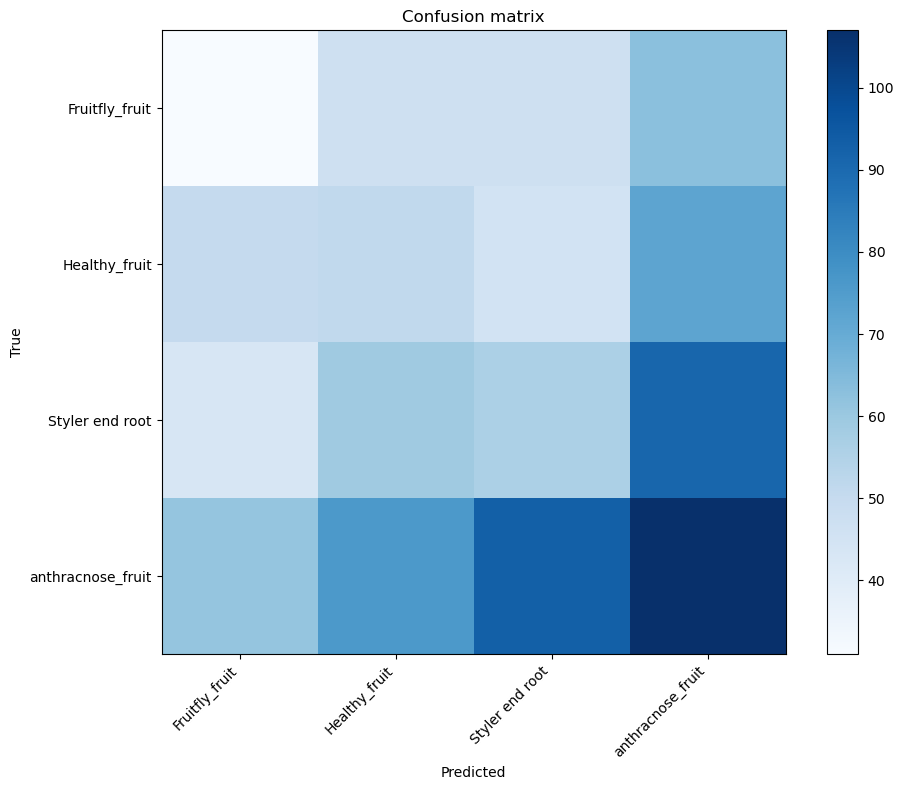

Model saved.


In [85]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title("Confusion matrix")
plt.colorbar()
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(np.arange(len(class_names)), class_names, rotation=45, ha='right')
plt.yticks(np.arange(len(class_names)), class_names)
plt.tight_layout()
plt.show()

# Save final model
model.save(os.path.join(RESULTS_DIR, f"final_model_{now}.keras"))
print("Model saved.")

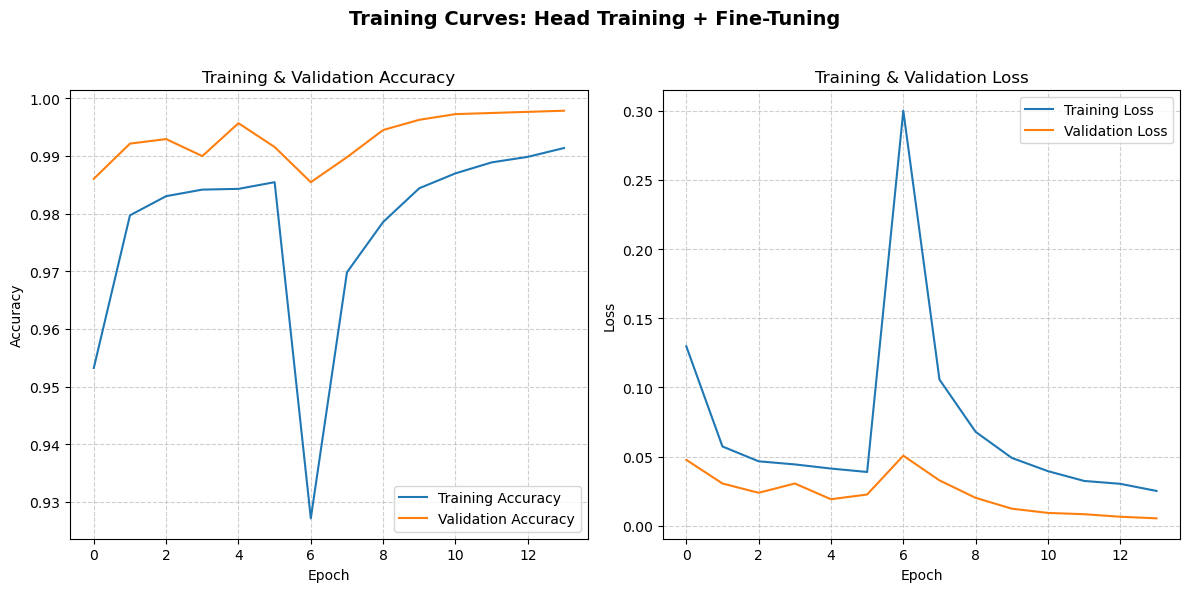

Training graphs saved to: results/training_curves_20251110-101814.png


In [87]:
# ========== Training Graphs (Accuracy & Loss) ==========

# Combine both history objects (head + fine-tune)
def combine_histories(h1, h2):
    acc = h1.history['accuracy'] + h2.history['accuracy']
    val_acc = h1.history['val_accuracy'] + h2.history['val_accuracy']
    loss = h1.history['loss'] + h2.history['loss']
    val_loss = h1.history['val_loss'] + h2.history['val_loss']
    return acc, val_acc, loss, val_loss

acc, val_acc, loss, val_loss = combine_histories(history_head, history_fine)

epochs_range = range(len(acc))

plt.figure(figsize=(12, 6))

# ---- Accuracy plot ----
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True, linestyle='--', alpha=0.6)

# ---- Loss plot ----
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True, linestyle='--', alpha=0.6)

plt.suptitle('Training Curves: Head Training + Fine-Tuning', fontsize=14, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Save graphs to results folder
graph_path = os.path.join(RESULTS_DIR, f"training_curves_{now}.png")
plt.savefig(graph_path, dpi=150)
plt.show()

print(f"Training graphs saved to: {graph_path}")
